<font color='tomato'><font color="#CC3D3D"><p>
# A Transformer-based recommendation system: BST

- 이 튜토리얼은 Keras에서 [Example](https://keras.io/examples/structured_data/movielens_recommendations_transformers/)로 제공하는 [Behavior Sequence Transformer (BST)](https://arxiv.org/abs/1905.06874) 코드를 보다 이해하기 쉽게 수정한 것임

- Keras Example과 다른 점은 아래와 같음:   
  - MovieLens 데이터를 사용한 평점 예측 => 백화점 구매데이터를 사용한 다음에 구매할 아이템 예측
  - Side Information을 모델에 반영하지 않음

<img align='left' src='http://drive.google.com/uc?export=view&id=19jbYkwNpXfMS12SyXL8AZ0YZfI2UQw96' width=800/>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [2]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

2.14.0


## 1. Prepare the data

### load the data

In [3]:
# 사전에 HDS 트랜잭션 데이터를 user features, item features, rating(1:3 negative sampling 적용)으로 분리
# 이 튜토리얼에서는 rating 데이터만 사용
users = pd.read_csv('/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/users.csv', dtype={'user_id': str})
items = pd.read_csv('/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/items.csv', dtype={'item_id': str}, encoding='cp949')
ratings = pd.read_csv('/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/ratings_neg3.csv', dtype={'user_id': str})

### Transform the ratings data into sequences

In [4]:
# 평점 데이터를 timestamp 순으로 정렬한 다음 item_id 값과 rating 값을 user_id에 따라 그룹화
ratings_group = ratings.sort_values(by=["timestamp"]).groupby("user_id")

# 각 user_id에 대해 timestamp 시간순으로 정렬된
# item_id 리스트, rating 리스트, timestamp 리스트를 나타내는 데이터 프레임 생성
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "item_ids": list(ratings_group.item_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.timestamp.apply(list)),
    }
)

ratings_data

,user_id,item_ids,ratings,timestamps
0,U00000,"[P2116050008000, P4228260113074, P422673101002...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[6251212, 6251212, 6251212, 6251212, 6251242, ..."
1,U00002,"[P4208763010000, P4301000017000, P450197004338...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[8271841, 8271841, 8271841, 8271841, 8271901, ..."
2,U00003,"[P4226470013074, P4551520040820, P442226002998...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[5131800, 5131800, 5131800, 5131800, 5131810, ..."
3,U00004,"[P4400040020053, P4210458013076, P412544000800...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[7271403, 7271403, 7271403, 7271403, 7271443, ..."
4,U00005,"[P4100560001120, P6315970019900, P410581400298...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[5041810, 5041810, 5041810, 5041810, 5041820, ..."
...,...,...,...,...
21582,U29995,"[P4229810011000, P4504630939001, P423465001308...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[5091253, 5091253, 5091253, 5091253, 5091323, ..."
21583,U29996,"[P4209510010030, P6322061019970, P630808101997...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[13111752, 13111752, 13111752, 13111752, 13191..."
21584,U29997,"[P4123493001100, P4547540945200, P410103300040...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[15111412, 15111412, 15111412, 15111412, 15111..."
21585,U29998,"[P6300141017000, P4105203210000, P430914101992...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[5071540, 5071540, 5071540, 5071540, 5071643, ..."


In [5]:
# item_ids, ratings 목록을 고정된 길이의 시퀀스 집합으로 분할하기 위해 관련 변수 설정
sequence_length = 4
step_size = 2

# 주어진 values(item/rating) 리스트에서 특정 window_size(sequence_length) 크기의 연속된 부분 리스트들을 생성하는 함수
# 여기서, step_size는 각 부분 리스트들 사이의 sequence 간격을 결정
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

# item 시퀀스 생성
ratings_data.item_ids = ratings_data.item_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)
# rating 시퀀스 생성
ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)
# 필요없는 변수 제거
del ratings_data["timestamps"]

ratings_data

,user_id,item_ids,ratings
0,U00000,"[[P2116050008000, P4228260113074, P42267310100...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
1,U00002,"[[P4208763010000, P4301000017000, P45019700433...","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
2,U00003,"[[P4226470013074, P4551520040820, P44222600299...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [..."
3,U00004,"[[P4400040020053, P4210458013076, P41254400080...","[[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0], [..."
4,U00005,"[[P4100560001120, P6315970019900, P41058140029...","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
...,...,...,...
21582,U29995,"[[P4229810011000, P4504630939001, P42346500130...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
21583,U29996,"[[P4209510010030, P6322061019970, P63080810199...","[[0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0], [..."
21584,U29997,"[[P4123493001100, P4547540945200, P41010330004...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
21585,U29998,"[[P6300141017000, P4105203210000, P43091410199...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [..."


In [6]:
# 각 시퀀스가 하나의 행이 되도록 변환
ratings_data_items = ratings_data[["user_id", "item_ids"]].explode( # explode(): 리스트형태의 값을 여러 행으로 전개하는 메서드
    "item_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_items, ratings_data_rating], axis=1) # 열 결합

# 리스트를 CS 문자열로 변환 (추후 tf.data.Dataset 생성을 위해. get_dataset_from_csv 참조)
ratings_data_transformed.item_ids = ratings_data_transformed.item_ids.apply( # [i1,i2,i3,i4] => "i1,i2,i3,i4"
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply( # [r1,r2,r3,r4] => "r1,r2,r3,r4"
    lambda x: ",".join([str(v) for v in x])
)

# 컬럼명 변경
ratings_data_transformed.rename(
    columns={"item_ids": "sequence_item_ids", "ratings": "sequence_ratings"}, # layers.Input의 name과 일치해야 함.
    inplace=True,
)

ratings_data_transformed

,user_id,sequence_item_ids,sequence_ratings
0,U00000,"P2116050008000,P4228260113074,P4226731010020,P...","1.0,0.0,0.0,0.0"
1,U00000,"P4226731010020,P6241000026010,P4553760041974,P...","0.0,0.0,0.0,0.0"
2,U00000,"P4553760041974,P4230880026274,P4544960046072,P...","0.0,0.0,0.0,1.0"
3,U00000,"P4544960046072,P4125440008000,P4239540015082,P...","0.0,1.0,0.0,0.0"
4,U00000,"P4239540015082,P6318120019971,P2116052008000,P...","0.0,0.0,1.0,0.0"
...,...,...,...
1250163,U29999,"P4109290004000,P4229620113074,P4139350206500,P...","1.0,0.0,1.0,0.0"
1250164,U29999,"P4139350206500,P4226960010020,P4236960010020,P...","1.0,0.0,0.0,0.0"
1250165,U29999,"P4236960010020,P4540620945370,P4405600026053,P...","0.0,0.0,0.0,0.0"
1250166,U29999,"P4405600026053,P4500590241400,P4221210013080,P...","0.0,0.0,0.0,1.0"


### Split data into train and test subsets

In [7]:
# 학습(85%)과 평가(15%) 데이터로 분할
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/train_data.csv", index=False)
test_data.to_csv("/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/test_data.csv", index=False)

### Create `tf.data.Dataset` for training and evaluation

In [8]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    # features의 각 컬럼명은 layers.Input의 name과 일치해야 함.
    def process(features):
        item_ids_string = features["sequence_item_ids"]
        sequence_item_ids = tf.strings.split(item_ids_string, ",").to_tensor()

        # The last item id in the sequence is the target item.
        features["target_item_id"] = sequence_item_ids[:, -1]
        features["sequence_item_ids"] = sequence_item_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        num_epochs=1,
        shuffle=shuffle,
    ).map(process)

    return dataset

## 2. Build a BST model

### Set parameters

In [9]:
HIDDEN_UNITS = [256, 128]
DROPOUT_RATE = 0.1
NUM_HEADS = 3
NUM_EPOCHS = 5
BATCH_SIZE = 256

### Input layer

In [10]:
sequence_item_ids = layers.Input(name="sequence_item_ids", shape=(sequence_length-1,), dtype=tf.string)
target_item_id = layers.Input(name="target_item_id", shape=(1,), dtype=tf.string)
sequence_ratings = layers.Input(name="sequence_ratings", shape=(sequence_length-1,), dtype=tf.float32)

inputs = [sequence_item_ids, target_item_id, sequence_ratings]

### Embedding layer

In [11]:
item_vocabulary = ratings.item_id.unique()
item_embedding_dims = int(math.sqrt(len(item_vocabulary))) # 임베딩 차원의 크기 = 아이템 수의 제곱근

# Encoding target_item_id
# target_item_id를 정수 인덱스로 변환 -> target item 임베딩 벡터 생성
item_idx = StringLookup(
    vocabulary=item_vocabulary,
    mask_token=None,
    num_oov_indices=0,
    name="item_index_lookup",
)(target_item_id)
encoded_target_item = layers.Embedding(
    input_dim=len(item_vocabulary),
    output_dim=item_embedding_dims,
    name=f"item_embedding",
)(item_idx)

# Encoding sequence item_ids
# sequence item_ids를 정수 인덱스로 변환 -> sequence item 임베딩 벡터 생성
item_idx = StringLookup(
    vocabulary=item_vocabulary,
    mask_token=None,
    num_oov_indices=0,
    name="sequence_index_lookup",
)(sequence_item_ids)
encoded_sequence_items = layers.Embedding(
    input_dim=len(item_vocabulary),
    output_dim=item_embedding_dims,
    name=f"sequence_embedding",
)(item_idx)

# Create positional embedding
# 0부터 sequence_length-1까지의 위치 인덱스 생성 -> 임베딩을 통해 각 위치에 대한 고유벡터를 생성함으로써 위치정보 표현
positions = tf.range(start=0, limit=sequence_length-1, delta=1) #
encodded_positions = layers.Embedding(
    input_dim=sequence_length,
    output_dim=item_embedding_dims,
    name="position_embedding",
)(positions)

# Retrieve sequence ratings to incorporate them into the encoding of the item
sequence_ratings = tf.expand_dims(sequence_ratings, -1)
# Add the positional encoding to the item encodings and multiply them by rating
# 각 아이템의 중요도를 반영하기 방식으로, 일반적인 positional encoding 방식과는 다름.
encoded_sequence_items_with_poistion_and_rating = layers.Multiply()(
    [(encoded_sequence_items + encodded_positions), sequence_ratings]
)

# Construct the transformer inputs:
# 시퀀스 내 각 아이템을 개별적으로 처리할 수 있게 분해 -> 타겟 아이템 추가 -> 모두 concat
transformer_features = []
for encoded_item in tf.unstack(encoded_sequence_items_with_poistion_and_rating, axis=1):
    transformer_features.append(tf.expand_dims(encoded_item, 1))
transformer_features.append(encoded_target_item)
transformer_features = layers.concatenate(transformer_features, axis=1)

### Transformer layer

In [12]:
# Create a multi-headed attention layer
# 시퀀스 내의 각 위치에서 다른 위치들에 대한 상대적 중요도 학습
attention_output = layers.MultiHeadAttention(
    num_heads=NUM_HEADS,
    key_dim=transformer_features.shape[2], # 임베딩 차원을 key/query/value 벡터의 차원으로 설정
    dropout=DROPOUT_RATE
)(transformer_features, transformer_features)

# Transformer block
attention_output = layers.Dropout(DROPOUT_RATE)(attention_output)
x1 = layers.Add()([transformer_features, attention_output])
x1 = layers.LayerNormalization()(x1)
x2 = layers.LeakyReLU()(x1)
x2 = layers.Dense(units=x2.shape[-1])(x2)
x2 = layers.Dropout(DROPOUT_RATE)(x2)
transformer_features = layers.Add()([x1, x2])
transformer_features = layers.LayerNormalization()(transformer_features)
features = layers.Flatten()(transformer_features)

### Fully-connected layer

In [14]:
for num_units in HIDDEN_UNITS:
    features = layers.Dense(num_units)(features)
    features = layers.BatchNormalization()(features)
    features = layers.LeakyReLU()(features)
    features = layers.Dropout(DROPOUT_RATE)(features)
outputs = layers.Dense(units=1, activation='sigmoid')(features)

# Final model
model = keras.Model(inputs=inputs, outputs=outputs)

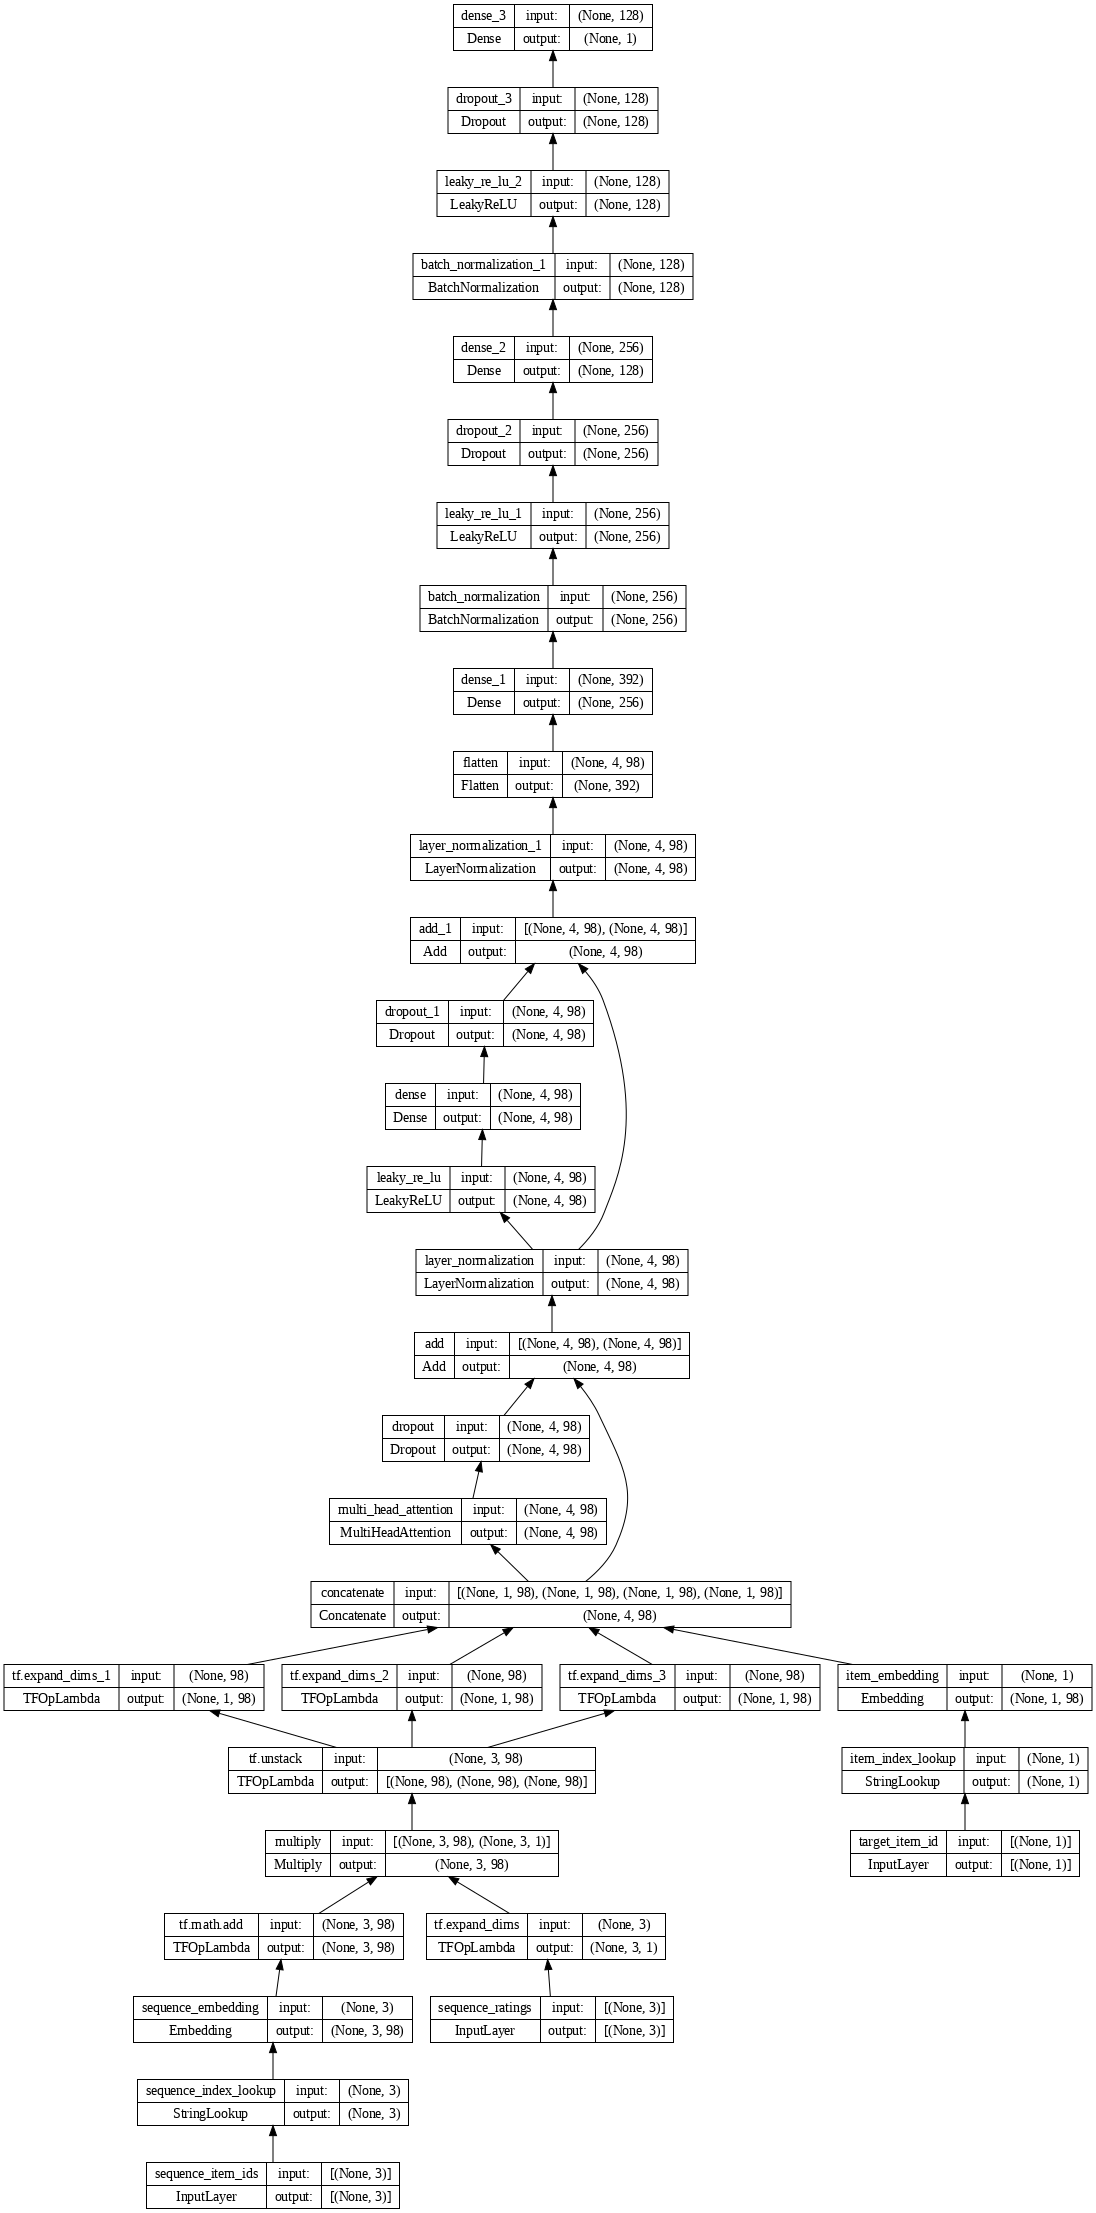

In [15]:
# Visualize the Network structure
tf.keras.utils.plot_model(model, rankdir="BT", dpi=72, show_shapes=True)

## 3. Run training and evaluation

### Set the optimizer and the cost function

In [16]:
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)

### Train the model

In [18]:
# Read the training data
train_dataset = get_dataset_from_csv("/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/train_data.csv", shuffle=True, batch_size=BATCH_SIZE)

# Fit the model with the training data
model.fit(train_dataset, epochs=NUM_EPOCHS, verbose=1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['user_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4154/4154 [==============================] - 289s 68ms/step - loss: 0.2567 - precision: 0.8129 - recall: 0.7072 - auc: 0.9382
Epoch 2/5
4154/4154 [==============================] - 266s 64ms/step - loss: 0.2144 - precision: 0.8630 - recall: 0.7702 - auc: 0.9582
Epoch 3/5
4154/4154 [==============================] - 270s 65ms/step - loss: 0.2081 - precision: 0.8560 - recall: 0.7872 - auc: 0.9611
Epoch 4/5
4154/4154 [==============================] - 266s 64ms/step - loss: 0.2047 - precision: 0.8536 - recall: 0.7949 - auc: 0.9626
Epoch 5/5
4154/4154 [==============================] - 273s 66ms/step - loss: 0.2031 - precision: 0.8519 - recall: 0.7980 - auc: 0.9634


### Evaluate the model

In [19]:
# Read the test data
test_dataset = get_dataset_from_csv("/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231118/test_data.csv", batch_size=BATCH_SIZE)

# Evaluate the model on the test data
_, precision, recall, auc = model.evaluate(test_dataset, verbose=0)
print(f"Test Precision:{round(precision, 3)}, Recall:{round(recall, 3)}, AUC:{round(auc, 3)}")

Test Precision:0.839, Recall:0.8, AUC:0.959


<font color='tomato'><font color="#CC3D3D"><p>
# End